# MLP

Same as MLP 17 but use noncoding RNA. 

MLP with one neuron. All K-mers, K=4, one byte counts with cap 255. Threshold=mean (fair test, not Gudenas). No scaling. 5-fold CV. RCI from cell line 0 = A549.

Cross validation acc mean 54.90% (+/- 5.02%) on binary classification of all lncRNA.

We used 20 epochs but 5 might suffice. Accuracy bounced up and down, so early stopping would help.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-21 09:12:25.066050
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization
from sklearn.preprocessing import StandardScaler

dt='float32'
tf.keras.backend.set_floatx(dt)

tf.random.set_seed(42) # reproducible training sessions?

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=20
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_noncoding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_noncoding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
      
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-21 09:12:37.920883
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-21 09:12:37.929342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-21 09:12:38.113054
Loaded values for cell line 0
Selected 1422 values out of 4622
2022-10-21 09:12:39.797534


## Train and validate with all K-mer counts

In [8]:
SCALING = False
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholds = splitter.choose_thresholds(train_genes,'mean')
        X_train,y_train,train_ids = splitter.get_X_y(train_genes, thresholds)
        X_valid,y_valid,valid_ids = splitter.get_X_y(valid_genes, thresholds)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Thresholds',thresholds)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-21 09:12:39.842898
2022-10-21 09:12:39.843223
splitting
Fold 1
Train sizes 5223 5223
Valid sizes 1534 1534
Thresholds (-0.4618886470474517, -0.4618886470474517)
Train set ones/size 3411 / 5223
Valid set ones/size 744 / 1534
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:12:39.886536
Epoch 1/20
164/164 [==============================] - 1s 3ms/step - loss: 1.7177 - accuracy: 0.5893 - val_loss: 1.6538 - val_accuracy: 0.4452
Epoch 2/20
164/164 [==============================] - 0s 2ms/step - loss: 1.1738 - accuracy: 0.6020 - val_loss: 1.5854 - val_accuracy: 0.4224
Epoch 3/20
164/164 [==============================] - 0s 2ms/step - loss: 1.0053 - accuracy: 0.6161 - val_loss: 1.4462 - val_accuracy: 0.4276
Epoch 4/20
164/164 [==============================] - 0s 2ms/step - loss: 0.9536 - accuracy: 0.6173 - val_loss: 1.4171 - val_accuracy: 0.4446
Epoch 5/20
164/164 [==============================] - 0s 2ms/step - loss: 0.8112 - accuracy: 0.6538 - val_loss: 1.1962 - val_accuracy:

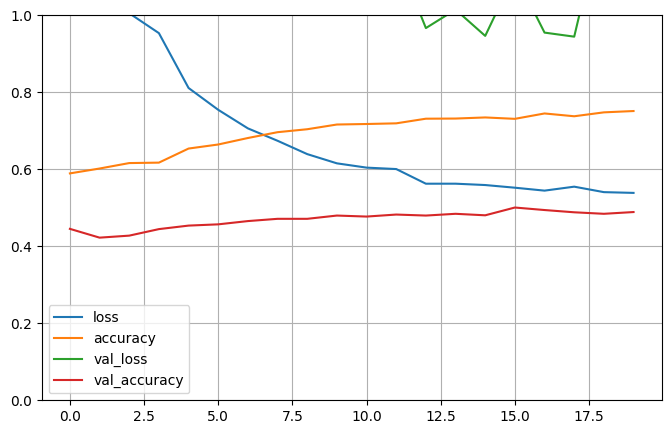

Compute valiation accuracy
2022-10-21 09:12:59.248267
accuracy: 48.89%
2022-10-21 09:12:59.445540
Fold 2
Train sizes 5673 5673
Valid sizes 1084 1084
Thresholds (-0.4754613112917399, -0.4754613112917399)
Train set ones/size 3508 / 5673
Valid set ones/size 652 / 1084
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:12:59.494585
Epoch 1/20
178/178 [==============================] - 1s 4ms/step - loss: 1.3485 - accuracy: 0.5886 - val_loss: 1.3207 - val_accuracy: 0.5434
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 1.0832 - accuracy: 0.6087 - val_loss: 1.2598 - val_accuracy: 0.5618
Epoch 3/20
178/178 [==============================] - 1s 3ms/step - loss: 0.9300 - accuracy: 0.6265 - val_loss: 1.2991 - val_accuracy: 0.5793
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 0.8322 - accuracy: 0.6460 - val_loss: 1.0460 - val_accuracy: 0.5747
Epoch 5/20
178/178 [==============================] - 1s 8ms/step - loss: 0.7680 - accuracy: 0.6605 

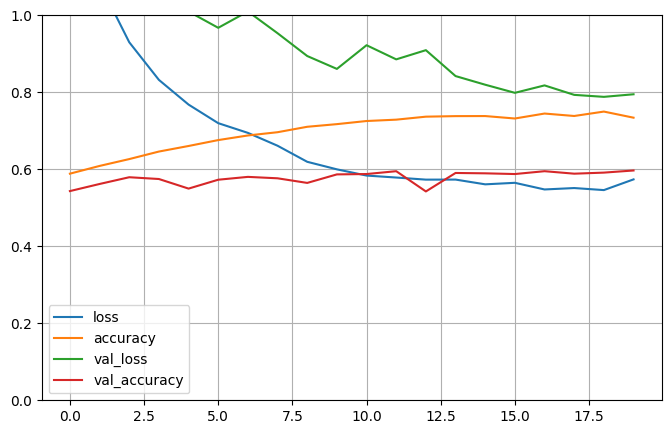

Compute valiation accuracy
2022-10-21 09:13:14.508941
accuracy: 59.69%
2022-10-21 09:13:14.638997
Fold 3
Train sizes 5292 5292
Valid sizes 1465 1465
Thresholds (-0.45677917384885763, -0.45677917384885763)
Train set ones/size 3085 / 5292
Valid set ones/size 1068 / 1465
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:13:14.687109
Epoch 1/20
166/166 [==============================] - 1s 4ms/step - loss: 1.5360 - accuracy: 0.5338 - val_loss: 1.1787 - val_accuracy: 0.6382
Epoch 2/20
166/166 [==============================] - 1s 3ms/step - loss: 1.1685 - accuracy: 0.5646 - val_loss: 1.1887 - val_accuracy: 0.6089
Epoch 3/20
166/166 [==============================] - 1s 3ms/step - loss: 1.0158 - accuracy: 0.5939 - val_loss: 1.0254 - val_accuracy: 0.6403
Epoch 4/20
166/166 [==============================] - 1s 3ms/step - loss: 0.9120 - accuracy: 0.6158 - val_loss: 1.0859 - val_accuracy: 0.5939
Epoch 5/20
166/166 [==============================] - 0s 3ms/step - loss: 0.7955 - accuracy: 0.63

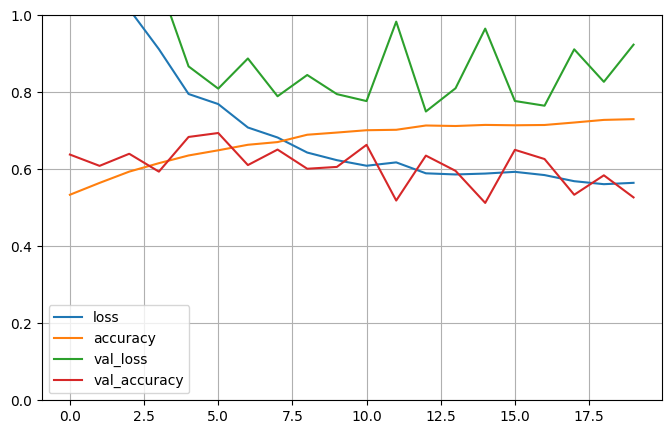

Compute valiation accuracy
2022-10-21 09:13:25.911919
accuracy: 52.70%
2022-10-21 09:13:26.042906
Fold 4
Train sizes 5470 5470
Valid sizes 1287 1287
Thresholds (-0.4807138250790861, -0.4807138250790861)
Train set ones/size 3345 / 5470
Valid set ones/size 818 / 1287
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:13:26.080587
Epoch 1/20
171/171 [==============================] - 1s 4ms/step - loss: 1.2711 - accuracy: 0.5766 - val_loss: 1.4006 - val_accuracy: 0.5221
Epoch 2/20
171/171 [==============================] - 1s 3ms/step - loss: 0.9806 - accuracy: 0.6265 - val_loss: 1.3107 - val_accuracy: 0.4981
Epoch 3/20
171/171 [==============================] - 1s 3ms/step - loss: 0.8674 - accuracy: 0.6450 - val_loss: 1.2029 - val_accuracy: 0.5004
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.7762 - accuracy: 0.6592 - val_loss: 1.0674 - val_accuracy: 0.5253
Epoch 5/20
171/171 [==============================] - 1s 6ms/step - loss: 0.7034 - accuracy: 0.6852 

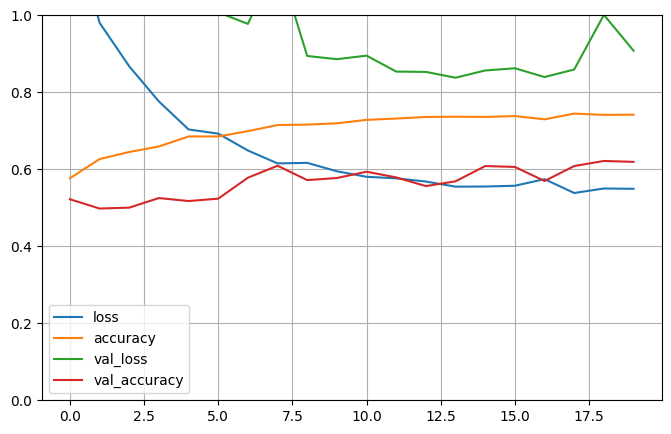

Compute valiation accuracy
2022-10-21 09:13:39.426264
accuracy: 61.93%
2022-10-21 09:13:39.576782
Fold 5
Train sizes 5377 5377
Valid sizes 1380 1380
Thresholds (-0.4927765818892794, -0.4927765818892794)
Train set ones/size 3361 / 5377
Valid set ones/size 921 / 1380
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-10-21 09:13:39.625029
Epoch 1/20
169/169 [==============================] - 2s 4ms/step - loss: 1.6531 - accuracy: 0.5503 - val_loss: 1.2472 - val_accuracy: 0.6261
Epoch 2/20
169/169 [==============================] - 1s 4ms/step - loss: 1.2658 - accuracy: 0.5706 - val_loss: 1.0980 - val_accuracy: 0.6210
Epoch 3/20
169/169 [==============================] - 1s 3ms/step - loss: 1.0655 - accuracy: 0.6037 - val_loss: 1.0267 - val_accuracy: 0.6029
Epoch 4/20
169/169 [==============================] - 1s 3ms/step - loss: 0.9415 - accuracy: 0.6293 - val_loss: 0.9464 - val_accuracy: 0.6181
Epoch 5/20
169/169 [==============================] - 0s 3ms/step - loss: 0.8331 - accuracy: 0.6491 

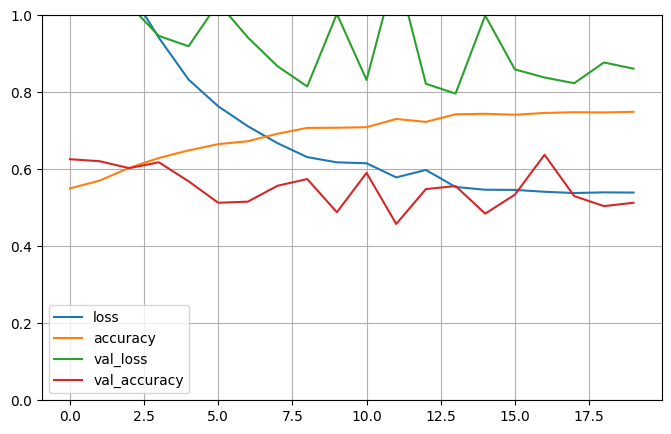

Compute valiation accuracy
2022-10-21 09:13:52.841719
accuracy: 51.30%
2022-10-21 09:13:52.965805

Cross validation acc mean 54.90% (+/- 5.02%)
2022-10-21 09:13:52.966799


In [9]:
print(datetime.now())
do_cross_validation(splitter,EPOCHS)    
print(datetime.now())